In [10]:
# Import all the libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import tensorflow_hub as tfhub
from functions import *

In [11]:
# Path of the PubMed dataset on the local repository
path_validation = 'C:\\Users\\gupta\\OneDrive\\Desktop\\GIT\\GIT Projects\\SKIMLIT\\pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\dev.txt'
path_train = 'C:\\Users\\gupta\\OneDrive\\Desktop\\GIT\\GIT Projects\\SKIMLIT\\pubmed-rct\\PubMed_20k_RCT_numbers_replaced_with_at_sign\\train.txt'
# Preprocessing the data and representing all the lines in the data as a dictionary (total_lines,line_number,text and target)
validation_text = preprocess(path_validation)
train_text = preprocess(path_train)

In [12]:
# Extracting the array of all the individual feilds for furthur processing
train_target = pd.DataFrame(train_text)['target'][:30000]
train_line_number = pd.DataFrame(train_text)['line_number'][:30000]
train_total_lines = pd.DataFrame(train_text)['total_lines'][:30000]
train_text = pd.DataFrame(train_text)['text'][:30000]

validation_target = pd.DataFrame(validation_text)['target']
validation_line_number = pd.DataFrame(validation_text)['line_number']
validation_total_lines = pd.DataFrame(validation_text)['total_lines']
validation_text = pd.DataFrame(validation_text)['text']

In [13]:
train_text.shape

(30000,)

In [14]:
# OneHotEncoding the total_lines, line_number and targets
train_line_number_encoded = tf.one_hot(train_line_number,depth=np.percentile(train_line_number,98))
train_total_lines_encoded = tf.one_hot(train_total_lines,depth=np.percentile(train_total_lines,98))

validation_line_number_encoded = tf.one_hot(validation_line_number,depth=np.percentile(validation_line_number,98))
validation_total_lines_encoded = tf.one_hot(validation_total_lines,depth=np.percentile(validation_total_lines,98))

one_hot = OneHotEncoder(sparse=False)
train_target = tf.reshape(train_target,shape=(-1,1))
train_target_encoded = one_hot.fit_transform(train_target)

validation_target = tf.reshape(validation_target,shape=(-1,1))
validation_target_encoded = one_hot.transform(validation_target)

char_train_text = [split_chars(sentence) for sentence in train_text]
char_validation_text = [split_chars(sentence) for sentence in validation_text]

In [15]:
# Initialise the token embedding
token_embedding = tfhub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable=False,name='Universal_sentence_encoder')

# 26 alphabets + ' ' + OOV token = 28  
NUM_CHARACTERS = 28
# Initialise the character vectorisation and embeddings
char_vectoriser = tf.keras.layers.TextVectorization(max_tokens=NUM_CHARACTERS)
char_vectoriser.adapt(char_train_text)
char_embedding = tf.keras.layers.Embedding(28,25,mask_zero=False)

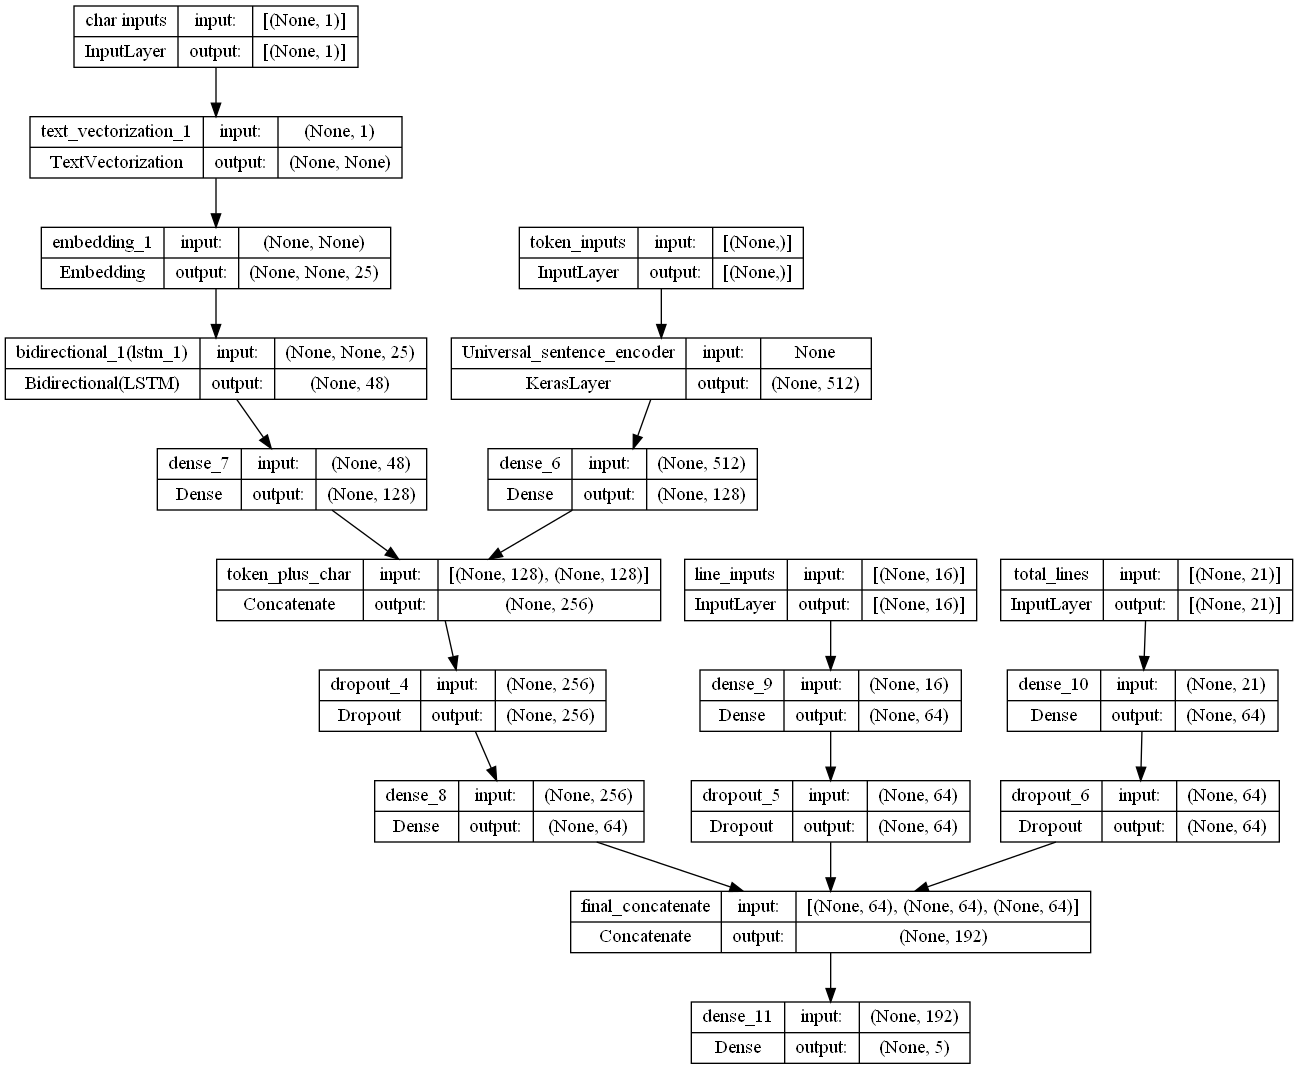

In [16]:
# Building the token Model...
token_inputs = tf.keras.layers.Input(shape=[],dtype=tf.string,name='token_inputs')
embedding_token = token_embedding(token_inputs)
token_dense = tf.keras.layers.Dense(units=128,activation='relu')(embedding_token)
token_model = tf.keras.Model(inputs=token_inputs,outputs=token_dense)

# Building the character Model...
char_inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string,name='char inputs')
vectoriser_char = char_vectoriser(char_inputs)
embedding_char = char_embedding(vectoriser_char)
charLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=24))(embedding_char)
char_dense = tf.keras.layers.Dense(units=128,activation='relu')(charLSTM)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_dense)

# Concatenate the outputs of token_model and char_model and feed_forward to ANN
concat_token_char = tf.keras.layers.Concatenate(name='token_plus_char')([token_model.output,char_model.output])
dropout1 = tf.keras.layers.Dropout(0.4)(concat_token_char)
dense1 = tf.keras.layers.Dense(units=64,activation='tanh')(dropout1)

# Building the line_number_inputs Model...
line_num_inputs = tf.keras.layers.Input(shape=(16,),dtype=tf.float32,name='line_inputs')
dense_line_1 = tf.keras.layers.Dense(units=64,activation='relu')(line_num_inputs)
drop_line_1 = tf.keras.layers.Dropout(0.4)(dense_line_1)
line_num_model = tf.keras.Model(inputs=line_num_inputs,outputs=drop_line_1)

# Building the total_lines_input Model...
total_lines_inputs = tf.keras.layers.Input(shape=(21,),dtype=tf.float32,name='total_lines')
dense_total_1 = tf.keras.layers.Dense(units=64,activation='relu')(total_lines_inputs)
drop_total_1 = tf.keras.layers.Dropout(0.4)(dense_total_1)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,outputs=drop_total_1)

# Concatenate the outputs of all the models and feed it to a Dense layer with softmax activation
concatenate_all = tf.keras.layers.Concatenate(name='final_concatenate')([dense1,line_num_model.output,total_lines_model.output])
dropout_final = tf.keras.layers.Dropout(0.5)
dense_final = tf.keras.layers.Dense(units=5,activation='softmax')(concatenate_all)

# Build the final SKIMLIT model and compile it
Skimlit = tf.keras.Model(inputs=(token_inputs,char_inputs,line_num_inputs,total_lines_inputs),outputs=dense_final)
Skimlit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

# Plot the model for better visualisation
tf.keras.utils.plot_model(Skimlit,show_shapes=True)


In [17]:
# Use the tf.data API to make faster and efficient datasets (both training and validation)
train_inputs = tf.data.Dataset.from_tensor_slices((train_text,char_train_text,train_line_number_encoded,train_total_lines_encoded))
train_labels = tf.data.Dataset.from_tensor_slices((train_target_encoded))
train_dataset = tf.data.Dataset.zip((train_inputs,train_labels)).batch(32).prefetch(tf.data.AUTOTUNE).cache()

validation_inputs = tf.data.Dataset.from_tensor_slices((validation_text,char_validation_text,validation_line_number_encoded,validation_total_lines_encoded))
validation_labels = tf.data.Dataset.from_tensor_slices((validation_target_encoded))
validation_dataset = tf.data.Dataset.zip((validation_inputs,validation_labels)).batch(32).prefetch(tf.data.AUTOTUNE).cache()

In [18]:
# Fit the SKIMLIT model to the datasets and record its history
history = Skimlit.fit(train_dataset,epochs=2,batch_size=32,validation_data=validation_dataset,validation_batch_size=32)

Epoch 1/2
938/938 [==============================] - 56s 57ms/step - loss: 0.6743 - accuracy: 0.7439 - val_loss: 0.4983 - val_accuracy: 0.8101
Epoch 2/2
938/938 [==============================] - 53s 56ms/step - loss: 0.4880 - accuracy: 0.8126 - val_loss: 0.4485 - val_accuracy: 0.8283
